In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from ephys_queries import db_setup_core, select_spike_times, select_discrete_data
from dotenv import load_dotenv
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
data_dir = Path(".").absolute().parent / "data"
fig_dir = Path(".").absolute().parent / "figs"

In [8]:
dfb = (
    pd.read_csv(data_dir / "baseline.csv")
    .loc[lambda x: 
         (x["group_name"].isin((
            "acute_citalopram", 
            "acute_saline", 
            "shock", 
            "sham", 
            "acute_cit", 
            "acute_sal"
                ))
        ) & (
         x["cluster"] != "no_baseline")]
)

In [4]:
group_names = ["acute_citalopram", "acute_saline", "shock", 
               "sham", "acute_cit", "acute_sal"]
block_name = "base_shock"
fs = 30000

load_dotenv()
engine, metadata = db_setup_core()
session= "hamilton_36"

In [5]:
(
    df[["neuron_id", "session_name","cluster"]]
    .groupby(['session_name', "cluster"])
    .apply(len)
    .reset_index()
    .loc[lambda x: x["session_name"]==session]
)

,session_name,cluster,0
53,hamilton_36,fast_firing,4
54,hamilton_36,slow_irregular,13
55,hamilton_36,slow_regular,7


In [6]:
df_spikes = (
    select_spike_times(
        engine, metadata, 
        block_name=block_name, 
        group_names=group_names,
        session_names=[session]
    )
    .assign(
        spiketimes= lambda x: x["spike_time_samples"].divide(fs)
    )
)
df_events = (
    select_discrete_data(
        engine, metadata, 
        block_name=block_name,
        group_names=group_names,
    )
    .loc[lambda x: x["session_name"]==session]
    .assign(
        event_s= lambda x: x["timepoint_sample"].divide(fs)
    )
)

In [10]:
df_spikes = df_spikes.merge(dfb[["neuron_id", "cluster"]])

In [11]:
df_spikes

,neuron_id,spike_time_samples,session_name,group_name,spiketimes,cluster
0,1911,54087095,hamilton_36,acute_cit,1802.903167,slow_irregular
1,1911,54096146,hamilton_36,acute_cit,1803.204867,slow_irregular
2,1911,54196858,hamilton_36,acute_cit,1806.561933,slow_irregular
3,1911,54205106,hamilton_36,acute_cit,1806.836867,slow_irregular
4,1911,54208189,hamilton_36,acute_cit,1806.939633,slow_irregular
...,...,...,...,...,...,...
61045,1960,73095177,hamilton_36,acute_cit,2436.505900,slow_irregular
61046,1960,73097016,hamilton_36,acute_cit,2436.567200,slow_irregular
61047,1960,73097078,hamilton_36,acute_cit,2436.569267,slow_irregular
61048,1960,73098328,hamilton_36,acute_cit,2436.610933,slow_irregular


In [14]:
from spiketimes.df.conversion import df_to_list


_, sr = df_to_list(df_spikes[df_spikes["cluster"] == "slow_regular"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

# _, stims = df_to_list(df_spikes[df_spikes["cluster"] == "slow_regular"],
#                spiketimes_col="spiketimes",
#                spiketrain_col="neuron_id")

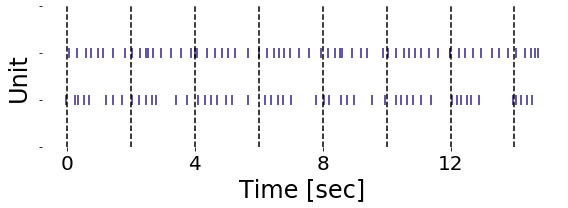

In [46]:
from spiketimes.plots import raster, add_event_vlines
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(8, 3))

t_start = 1900.3
t_stop = t_start + 15

events = (
    df_events[
        (df_events["event_s"] >= t_start) & (df_events["event_s"] <= t_stop)]
    ["event_s"].values
)

ax = raster(sr[:2], s=95, ax=ax, t_start=t_start, t_stop=t_stop,
           color="#332288")

ax.set_yticks(ticks=[-1, 0, 1, 2])
ax.set_yticklabels([])

ax.set_xticks(ticks=events[::2])
ax.set_xticklabels([0, 4, 8, 12], fontsize=20)


ax.set(frame_on=False)

ax.set_ylabel("Unit", fontsize=24)
ax.set_xlabel("Time [sec]", fontsize=24)

add_event_vlines(ax, events)

plt.tight_layout()
plt.savefig(fig_dir / "srsr_evoked.svg", transparent=True, dpi=300)

In [28]:
_, sr = df_to_list(df_spikes[df_spikes["cluster"] == "slow_regular"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")
_, fr = df_to_list(df_spikes[df_spikes["cluster"] == "slow_regular"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

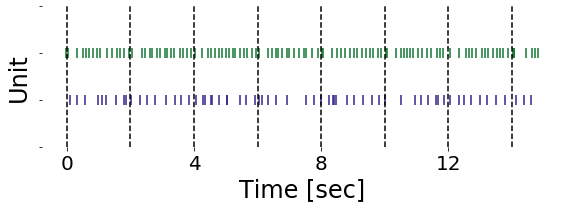

In [45]:
from spiketimes.plots import raster, add_event_vlines
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(8, 3))

t_start = 1900.3
t_stop = t_start + 15

events = (
    df_events[
        (df_events["event_s"] >= t_start) & (df_events["event_s"] <= t_stop)]
    ["event_s"].values
)

ax = raster([sr[4], []], s=95, ax=ax, t_start=t_start, t_stop=t_stop,
           color="#332288")
ax = raster([fr[3], []], s=95, ax=ax, t_start=t_start, t_stop=t_stop,
           color="#117733", _starting_ytick=1)

ax.set_yticks(ticks=[-1, 0, 1, 2])
ax.set_yticklabels([])

ax.set_xticks(ticks=events[::2])
ax.set_xticklabels([0, 4, 8, 12], fontsize=20)


ax.set(frame_on=False)

ax.set_ylabel("Unit", fontsize=24)
ax.set_xlabel("Time [sec]", fontsize=24)

add_event_vlines(ax, events)

plt.tight_layout()
plt.savefig(fig_dir / "frfr_evoked.svg", transparent=True, dpi=300)